In [1]:
import collections
import math
import numpy as np
from os.path import isfile, isdir
import random
from tqdm import tqdm
import tarfile
import text_helpers
import tensorflow as tf
from urllib.request import urlretrieve

In [2]:
dataset_folder_path = 'rt-polaritydata'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('rt-polaritydata.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='rt-polaritydata.tar.gz') as pbar:
        urlretrieve(
            'http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz',
            'rt-polaritydata.tar.gz',
            pbar.hook)

if not isdir(dataset_folder_path):
    with tarfile.open('rt-polaritydata.tar.gz') as tar:
        tar.extractall()
        tar.close()

In [3]:
vocabulary_size = 10000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

In [4]:
# Build dictionary of words
def build_dictionary(sentences, vocabulary_size):
    # Turn sentences (list of strings) into lists of words
    split_sentences = [s.split() for s in sentences]
    words = [x for sublist in split_sentences for x in sublist]
    
    # Initialize list of [word, word_count] for each word, starting with unknown
    count = [['UNK', -1]]
    
    # Now add most frequent words, limited to the N-most frequent (N=vocabulary size)
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    
    # Now create the dictionary
    word_dict = {}
    # For each word, that we want in the dictionary, add it, then make it
    # the value of the prior dictionary length
    for word, _ in count:
        word_dict[word] = len(word_dict)
    
    data = []
    unk_count = 0
    for word in words:
        if word in word_dict:
            index = word_dict[word]
        else:
            index = 0 
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(word_dict.values(), word_dict.keys())) 
    
    return data, count, word_dict, reverse_dictionary

In [5]:
texts, target = text_helpers.load_movie_data(dataset_folder_path)

In [6]:
data, count, dictionary, reverse_dictionary= build_dictionary(texts, 10000)

In [7]:
print('Most common words (+UNK)', count[:10])
print('Sample data', data[:10])

Most common words (+UNK) [['UNK', 11809], ('.', 14010), ('the', 10096), (',', 10037), ('a', 7281), ('and', 6195), ('of', 6061), ('to', 4233), ('is', 3367), ('in', 2628)]
Sample data [2, 648, 8, 2730, 7, 22, 2, 3437, 0, 101]


In [8]:
print('data:', [reverse_dictionary[di] for di in data[:20]])

data: ['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'UNK', 'new', '"', 'conan', '"', 'and', 'that', "he's", 'going', 'to', 'make', 'a']


### Skip-gram

In [9]:
data_index = 0

# Generate data randomly (N words behind, target, N words ahead)
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  # num_skips 
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

In [10]:
print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st']

with num_skips = 2 and skip_window = 1:
    batch: ['rock', 'rock', 'is', 'is', 'destined', 'destined', 'to', 'to']
    labels: ['is', 'the', 'destined', 'rock', 'is', 'to', 'destined', 'be']

with num_skips = 4 and skip_window = 2:
    batch: ['is', 'is', 'is', 'is', 'destined', 'destined', 'destined', 'destined']
    labels: ['to', 'rock', 'the', 'destined', 'to', 'rock', 'be', 'is']


In [12]:
valid_words = ['cliche', 'love', 'hate', 'silly', 'sad']
# Get validation word keys
valid_examples = [dictionary[x] for x in valid_words]

In [13]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.float32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(tf.nn.nce_loss(weights=softmax_weights, biases=softmax_biases,
                                       labels=train_labels,
                                       inputs=embed,
                                       num_sampled=num_sampled,
                                       num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [19]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for j in range(len(valid_words)):
            valid_word = reverse_dictionary[valid_examples[j]]
            top_k = 5 # number of nearest neighbors
            nearest = (-sim[j, :]).argsort()[1:top_k+1]
            log_str = "Nearest to {}:".format(valid_word)
            for k in range(top_k):
                close_word = reverse_dictionary[nearest[k]]
                log_str = "%s %s," % (log_str, close_word)
            print(log_str)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 242.206131
Nearest to cliche: …an, awe, curiosity, smarter, fulfills,
Nearest to love: deliberate, kiss, renowned, cyber, loveable,
Nearest to hate: unremittingly, ample, undercurrent, seduce, stumbles,
Nearest to silly: payami, quick, passionately, noticeable, states,
Nearest to sad: angry, modestly, ayurveda, quirkiness, enjoys,
Average loss at step 2000: 40.904681
Average loss at step 4000: 7.501193
Average loss at step 6000: 5.103631
Average loss at step 8000: 4.778532
Average loss at step 10000: 4.649418
Nearest to cliche: awe, …an, victim, cleverness, smarter,
Nearest to love: optimistic, sensuous, brainless, densely, renowned,
Nearest to hate: old-school, traces, undercurrent, loyalty, plastic,
Nearest to silly: margaritas, besson's, chuckle, passionately, genocide,
Nearest to sad: angry, chekhov, ayurveda, modestly, quickly,
Average loss at step 12000: 4.514102
Average loss at step 14000: 4.439920
Average loss at step 16000: 4.360844
Average 

In [20]:
from sklearn.manifold import TSNE
from matplotlib import pylab

num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

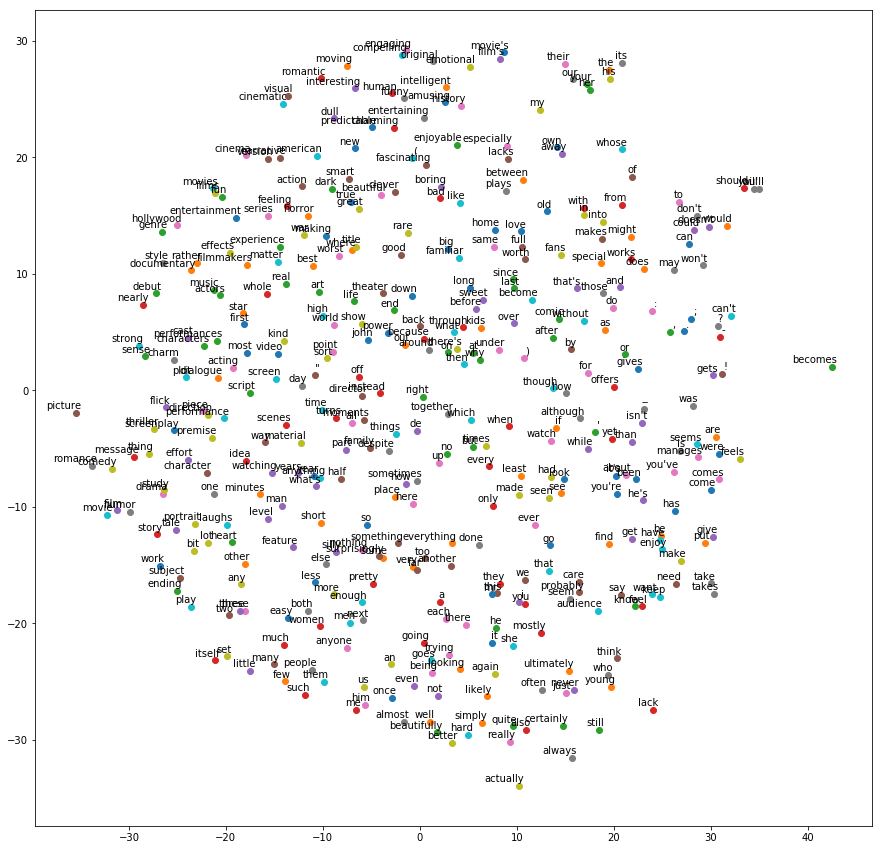

In [21]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)